In [ ]:
import os
import re

import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.ensemble import RandomForestRegressor
from collections import Counter


sns.set()
%matplotlib inline

In [ ]:
items, categ, sales_train, sample_sub, shops, test = [pd.read_csv('Store sales/' + file) for file in os.listdir('Store sales')[0:6]]
sales_train['date'] = pd.to_datetime(sales_train['date'])
files = [items, categ, sales_train, sample_sub, shops, test]
NAMES = ['items', 'categories', 'sales_train', 'sample_submission', 'shops', 'test']

holidays = pd.read_csv('days.csv')
items_mon = pd.read_csv('items_mon.csv')

holidays['date'] = pd.to_datetime(holidays['date'])

def save(where, what=sales_train, fast='Store sales/'):
    what.to_csv(path_or_buf='{}{}.csv'.format(fast, where), index=False, date_format='%Y-%m-%d')
    
def read(where, fast='Store sales/'):
    return pd.read_csv('{}{}.csv'.format(fast, where))

# Basic preprocessing and feature engineering

## View files

In [ ]:
for file, name in zip(files, NAMES):
    print(name, '\n', file.head(10), end='\n' + 25*'-' + '\n')

items 
                                            item_name  item_id  \
0                      во власти наваждения пласт .         0   
1  abbyy finereader 12 professional edition full ...        1   
2                                 в лучах славы unv         2   
3                                голубая волна univ         3   
4                                    коробка стекло         4   
5                   новые американские граффити uni         5   
6                               удар по воротам uni         6   
7                             удар по воротам 2 uni         7   
8                                    чай с муссолини        8   
9                        шугарлэндский экспресс uni         9   

   item_category_id  inactive  
0                40         1  
1                76         1  
2                40         1  
3                40         1  
4                40         1  
5                40         1  
6                40         1  
7                40 

In [ ]:
for file, name in zip(files, NAMES):
    print(name + '\n', file.describe(), end='\n' + 25*'-' + '\n')

items
            item_id  item_category_id      inactive
count  22170.00000      22170.000000  22170.000000
mean   11084.50000         46.290753      0.524538
std     6400.07207         15.941486      0.499409
min        0.00000          0.000000      0.000000
25%     5542.25000         37.000000      0.000000
50%    11084.50000         40.000000      1.000000
75%    16626.75000         58.000000      1.000000
max    22169.00000         83.000000      1.000000
-------------------------
categ
        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-------------------------
sales_train
        date_block_num       shop_id       item_id  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.301237e+01  1.019723e+04  1.242641e+00
std      9.422988e+00  1.621013e+01  6.324297e+03  2.6

## Categories

In [ ]:
categ

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [ ]:
categ['type'] = categ['item_category_name'].apply(lambda x: x.split()[0])

In [ ]:
save('item_categories', categ)

## Items

### Item_names

In [ ]:
list(items['item_name'])

['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D',
 '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]',
 '***В ЛУЧАХ СЛАВЫ   (UNV)                    D',
 '***ГОЛУБАЯ ВОЛНА  (Univ)                      D',
 '***КОРОБКА (СТЕКЛО)                       D',
 '***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)             D',
 '***УДАР ПО ВОРОТАМ (UNI)               D',
 '***УДАР ПО ВОРОТАМ-2 (UNI)               D',
 '***ЧАЙ С МУССОЛИНИ                     D',
 '***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D',
 '*ЗА ГРАНЬЮ СМЕРТИ                       D',
 '*ЛИНИЯ СМЕРТИ                           D',
 '*МИХЕЙ И ДЖУМАНДЖИ  Сука любовь',
 '*СПАСАЯ ЭМИЛИ                           D',
 '*ЧОКНУТЫЙ ПРОФЕССОР /МАГИЯ/             D',
 '//АДРЕНАЛИН: ОДИН ПРОТИВ ВСЕХ (Регион)',
 '//МОНГОЛ С.Бодров (Регион)',
 '//НЕ ОСТАВЛЯЮЩИЙ СЛЕДА (Регион)',
 '/БОМБА ДЛЯ НЕВЕСТЫ /2DVD/               D',
 '/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72',
 '/ОДНАЖДЫ В КИТАЕ-2',
 '/ПОСЛЕДНИЙ ШАНС',
 '/ПРОКЛЯТЬЕ ЭЛЬ ЧАРРО',
 '/СЕВЕР И ЮГ 

In [ ]:
items.isna().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [ ]:
# Copy item_name column in order not to ruin any initial information
item_names = items['item_name']

In [ ]:
item_names = item_names.str.lstrip('! */')
item_names = item_names.str.rstrip(' D')
item_names = item_names.str.lower()

for pattern, repl in zip([r'[(),/|\-:\'\"\[\]]+', r'.', r',', r' +'], [' ', ' . ', ' . ', ' ']):
    item_names = item_names.str.replace(pat=pattern, repl=repl, regex=True)

In [ ]:
all_words = item_names.str.split()
all_words = [word for lst in all_words for word in lst]

counter = Counter(all_words)

In [ ]:
counter = pd.DataFrame({'words':counter.keys(), 'occurences':counter.values()})

array([[<AxesSubplot:title={'center':'occurences'}>]], dtype=object)

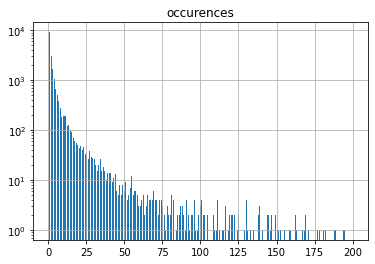

In [ ]:
counter.hist(log=True, bins=300, range=(0, 200))

In [ ]:
counter.sort_values(by='occurences', ascending=False).head(50)

,words,occurences
4,.,9599
13,версия,3599
11,pc,2682
99,bd,2010
12,цифровая,2003
54,регион,1849
30,2,1768
92,русская,1452
94,jewel,1370
41,и,1247


In [ ]:
items['item_name'] = item_names

In [ ]:
save(items, 'items')

### Sleeping items

In [ ]:
items

,item_name,item_id,item_category_id,inactive
0,во власти наваждения пласт .,0,40,1
1,abbyy finereader 12 professional edition full ...,1,76,1
2,в лучах славы unv,2,40,1
3,голубая волна univ,3,40,1
4,коробка стекло,4,40,1
...,...,...,...,...
22165,ядерный титбит 2 pc цифровая версия,22165,31,1
22166,язык запросов 1с предприятия цифровая версия,22166,54,0
22167,язык запросов 1с предприятия 8 +cd . хрусталев...,22167,49,0
22168,яйцо для little inu,22168,62,1


In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday_x,year,month,day,day_of_week,weekend,is_holiday_y
0,2013-01-02,0,59,22154,999.00,1.0,0.0,2013,1,2,2,0,1.0
1,2013-01-03,0,25,2552,899.00,1.0,0.0,2013,1,3,3,0,1.0
2,2013-01-05,0,25,2552,899.00,-1.0,1.0,2013,1,5,5,1,1.0
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,2013,1,6,6,1,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,0.0,2013,1,15,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,1.0,2015,10,10,5,1,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0,0.0,2015,10,9,4,0,0.0
2935846,2015-10-14,33,25,7459,349.00,1.0,0.0,2015,10,14,2,0,0.0
2935847,2015-10-22,33,25,7440,299.00,1.0,0.0,2015,10,22,3,0,0.0


In [ ]:
sales_train.drop('is_holiday_y', axis=1, inplace=True)
sales_train.rename({'is_holiday_x':'is_holiday'}, axis=1, inplace=True)

In [ ]:
sales_train

,shop_id,item_id,date_block_num,dummy,item_cnt_day
0,2,30,0,0,0.0
1,2,30,1,0,0.0
2,2,30,2,0,1.0
3,2,30,3,0,0.0
4,2,30,4,0,0.0
...,...,...,...,...,...
7496995,59,22167,30,0,0.0
7496996,59,22167,31,0,0.0
7496997,59,22167,32,0,0.0
7496998,59,22167,33,0,0.0


In [ ]:
items_mon = sales_train.pivot_table(index='date_block_num', columns='item_id', values='item_cnt_day', aggfunc='sum').fillna(0)
items_mon = items_mon.apply(lambda x: x > 0).astype(int)

items_mon = items_mon.T
items_mon[34] = 0
items_mon = items_mon.T

In [ ]:
items_mon = items_mon.rolling(axis=0, window=6).sum().shift(1, axis=0).fillna(method='bfill')
items_mon = items_mon.apply(lambda x: x > 0)

In [ ]:
items_mon

item_id,30,31,32,33,38,42,45,51,53,57,...,22118,22137,22139,22145,22154,22162,22163,22164,22166,22167
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
1,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
2,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
3,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
4,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
5,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
6,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
7,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False
8,True,True,True,True,False,True,True,True,True,True,...,False,False,True,False,True,False,False,False,False,False


In [ ]:
save('items_mon.csv', items_mon, fast='')

## Shops

In [ ]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [ ]:
sales_train.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=True)

shop_id
36       330.0
11       572.0
8       3595.0
40      4943.0
33      5482.0
20      5872.0
1       6311.0
34      6451.0
23      7705.0
32      8781.0
0      11705.0
9      15866.0
39     16617.0
49     17090.0
13     19763.0
10     24523.0
48     24909.0
17     25838.0
3      28355.0
2      30620.0
45     41895.0
5      42762.0
4      43942.0
44     44938.0
37     46256.0
14     46375.0
51     48767.0
59     48993.0
41     49324.0
52     49744.0
43     50608.0
38     53886.0
29     58713.0
22     60230.0
30     60828.0
16     61633.0
53     61657.0
55     63388.0
24     63886.0
18     65486.0
7      67058.0
47     67637.0
26     67890.0
21     68560.0
35     69016.0
15     71201.0
19     73455.0
12     73478.0
50     76238.0
56     78079.0
46     78990.0
58     81734.0
6     100489.0
27    136657.0
57    141107.0
42    144934.0
28    184557.0
54    185790.0
25    241920.0
31    310777.0
Name: item_cnt_day, dtype: float64

We see strange behaviour in shops with id 0, 1, 10, 11. Probably, it is a result of duplicates.

In [ ]:
shops.drop([0, 10], inplace=True)
shops.loc[1, 'shop_name'] = shops.loc[1, 'shop_name'].lstrip('!')

In [ ]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

In [ ]:
for name_r, name_e in zip(['ТЦ', 'ТРК', 'ТК', 'ТРЦ'], ['tc', 'tr', 'tk', 'trc']):
    shops['is_{}'.format(name_e)] = shops['shop_name'].str.contains(name_r).astype(int)

In [ ]:
shops.drop('shop_name', axis=1, inplace=True)

In [ ]:
shops.loc[[9, 12, 55], 'city'] = 'Выездная'

In [ ]:
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 1
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11

In [ ]:
save('shops', shops)
save('sales_train', sales_train)

### Find overpriced shops

In [ ]:
sales_train = pd.merge(sales_train, sales_train.groupby('item_id')[['item_price']].mean(). \
                       rename({'item_price':'mean_price'}, axis=1), left_on='item_id', right_index=True)

sales_train['expected_revenue'] = sales_train['item_cnt_day'] * sales_train['mean_price']

shop_overpriced = sales_train.groupby('shop_id')[['revenue', 'expected_revenue']].sum()
shop_overpriced['overprice_ratio'] = shop_overpriced['revenue'] / shop_overpriced['expected_revenue']

shops = pd.merge(shops, shop_overpriced, left_on='shop_id', right_index=True).drop(['revenue', 'expected_revenue'], axis=1)

save('shops', shops)

## Sales train

### Dealing with all holidays in Russia

In [ ]:
holidays = pd.read_csv('days')

In [ ]:
holidays.reset_index(inplace=True)
holidays = holidays.iloc[14: 17, 1:14]

In [ ]:
holidays

,Год/Месяц,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
14,2013,"1,2,3,4,5,6,7,8,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","1,2,3,4,5,8*,9,10,11,12,18,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,4,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29,31*"
15,2014,"1,2,3,4,5,6,7,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24*","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,4,8*,9,10,11,17,18,24,25,31","1,7,8,11*,12,13,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,3,4,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28"
16,2015,"1,2,3,4,5,6,7,8,9,10,11,17,18,24,25,31","1,7,8,14,15,21,22,23,28","1,7,8,9,14,15,21,22,28,29","4,5,11,12,18,19,25,26,30*","1,2,3,4,8*,9,10,11,16,17,23,24,30,31","6,7,11*,12,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","3,4,10,11,17,18,24,25,31","1,3*,4,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27,31*"


In [ ]:
holidays.columns = ['year'] + list(range(1, 13))

In [ ]:
holidays.set_index('year', inplace=True)

In [ ]:
holidays = pd.DataFrame(holidays.stack()).reset_index()
holidays.columns = ['year', 'month', 'days']

In [ ]:
holidays['days'] = holidays['days'].str.replace('*', '')

<ipython-input-16-0de2091fc845>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  holidays['days'] = holidays['days'].str.replace('*', '')


In [ ]:
holidays['days'] = holidays['days'].apply(lambda x: pd.Series(x.split()))

In [ ]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    36 non-null     int64 
 1   month   36 non-null     int64 
 2   days    36 non-null     object
dtypes: int64(2), object(1)
memory usage: 992.0+ bytes


In [ ]:
days = list([int(num) for num in x.split(',')] for x in holidays['days'])
len(days) == 36

True

In [ ]:
holidays.set_index(['year', 'month'])

days
year month                                        
2013 1           1,2,3,4,5,6,7,8,12,13,19,20,26,27
     2                     2,3,9,10,16,17,22,23,24
     3              2,3,7,8,9,10,16,17,23,24,30,31
     4                       6,7,13,14,20,21,27,28
     5          1,2,3,4,5,8,9,10,11,12,18,19,25,26
     6             1,2,8,9,11,12,15,16,22,23,29,30
     7                       6,7,13,14,20,21,27,28
     8                    3,4,10,11,17,18,24,25,31
     9                     1,7,8,14,15,21,22,28,29
     10                      5,6,12,13,19,20,26,27
     11                  2,3,4,9,10,16,17,23,24,30
     12                 1,7,8,14,15,21,22,28,29,31
2014 1           1,2,3,4,5,6,7,8,11,12,18,19,25,26
     2                      1,2,8,9,15,16,22,23,24
     3              1,2,7,8,9,10,15,16,22,23,29,30
     4                    5,6,12,13,19,20,26,27,30
     5            1,2,3,4,8,9,10,11,17,18,24,25,31
     6            1,7,8,11,12,13,14,15,21,22,28,29
     7                       5,6,12,13,19,20,26,27
     8                  2,3,9,10,16,17,23,24,30,31
     9                       6,7,13,14,20,21,27,28
     10                      4,5,11,12,18,19,25,26
     11              1,2,3,4,8,9,15,16,22,23,29,30
     12                      6,7,13,14,20,21,27,28
2015 1      1,2,3,4,5,6,7,8,9,10,11,17,18,24,25,31
     2                     1,7,8,14,15,21,22,23,28
     3                   1,7,8,9,14,15,21,22,28,29
     4                    4,5,11,12,18,19,25,26,30
     5         1,2,3,4,8,9,10,11,16,17,23,24,30,31
     6                 6,7,11,12,13,14,20,21,27,28
     7                       4,5,11,12,18,19,25,26
     8                   1,2,8,9,15,16,22,23,29,30
     9                       5,6,12,13,19,20,26,27
     10                   3,4,10,11,17,18,24,25,31
     11                1,3,4,7,8,14,15,21,22,28,29
     12                   5,6,12,13,19,20,26,27,31

In [ ]:
holidays = [[pd.to_datetime({'year':[moment.year], 'month':[moment.month], 'day':[day]}) for day in month]
                for month, moment in zip(days, pd.date_range('2013-01', '2016-01', freq='m'))]

In [ ]:
holidays = pd.DataFrame([holiday for month in holidays for holiday in month]).rename({0:'date'}, axis=1)
holidays['is_holiday'] = 1

In [ ]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train = pd.merge(sales_train, holidays, on='date', how='left').fillna(0)

In [ ]:
# save('sales_train')
save('days', what=holidays, fast='')

### Solving date issues

We see that multiple times there are a problem with dates, when month and days in wrong positions

In [ ]:
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day

In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,0.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,0.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,0.0,2013,1,15
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,1.0,2015,10,10
2935845,2015-10-09,33,25,7460,299.00,1.0,0.0,2015,10,9
2935846,2015-10-14,33,25,7459,349.00,1.0,0.0,2015,10,14
2935847,2015-10-22,33,25,7440,299.00,1.0,0.0,2015,10,22


In [ ]:
sales_train['fake_block'] = 12 * (sales_train['year'] - 2013) + sales_train['month'] - 1

In [ ]:
a = sales_train.query('date_block_num != fake_block')
a.groupby('day').count()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,fake_block
day,,,,,,,,,,


In [ ]:
x = sales_train.query('date_block_num != fake_block').index

sales_train.loc[x, 'date'] = pd.to_datetime({'year':sales_train.loc[x, 'year'],
                                             'month':sales_train.loc[x, 'day'],
                                             'day':sales_train.loc[x, 'month']})

In [ ]:
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day

sales_train['fake_block'] = 12 * (sales_train['year'] - 2013) + sales_train['month'] - 1
sales_train.query('date_block_num != fake_block')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,day,fake_block


In [ ]:
sales_train.drop('fake_block', axis=1, inplace=True)

In [ ]:
save('sales_train')

### Find inactive shops

In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,0.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,0.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,0.0,2013,1,15
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,1.0,2015,10,10
2935845,2015-10-09,33,25,7460,299.00,1.0,0.0,2015,10,9
2935846,2015-10-14,33,25,7459,349.00,1.0,0.0,2015,10,14
2935847,2015-10-22,33,25,7440,299.00,1.0,0.0,2015,10,22


In [ ]:
print('unique shops in train:', sales_train.shop_id.nunique())
print('unique shops in test:', test.shop_id.nunique(), end='\n\n')

print('unique items in train:', sales_train.item_id.nunique())
print('unique items in test:', test.item_id.nunique())

unique shops in train: 58
unique shops in test: 42

unique items in train: 21807
unique items in test: 5100


In [ ]:
shop_assortiment = sales_train.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', aggfunc='count'). \
    fillna(0).apply(lambda x: x > 0).astype(int)

In [ ]:
shop_assortiment

item_id,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
shop_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
save('shop_assortiment', shop_assortiment, fast='')

In [ ]:
temp = sales_train.groupby(['shop_id', 'date_block_num'])[['item_cnt_day']].sum()
temp.reset_index(inplace=True)

In [ ]:
zeros = pd.DataFrame(data=2040*[0], index=pd.MultiIndex.from_product([range(60), range(34)]))
zeros.reset_index(inplace=True)
zeros.columns = ['shop_id', 'date_block_num', 'dummy']

In [ ]:
zeros

,shop_id,date_block_num,dummy
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
2035,59,29,0
2036,59,30,0
2037,59,31,0
2038,59,32,0


In [ ]:
temp = pd.merge(temp, zeros, how='right').fillna(0).drop('dummy', axis=1).rename({'item_cnt_day':'monthly sales'}, axis=1)
temp.set_index(['shop_id', 'date_block_num'], inplace=True)

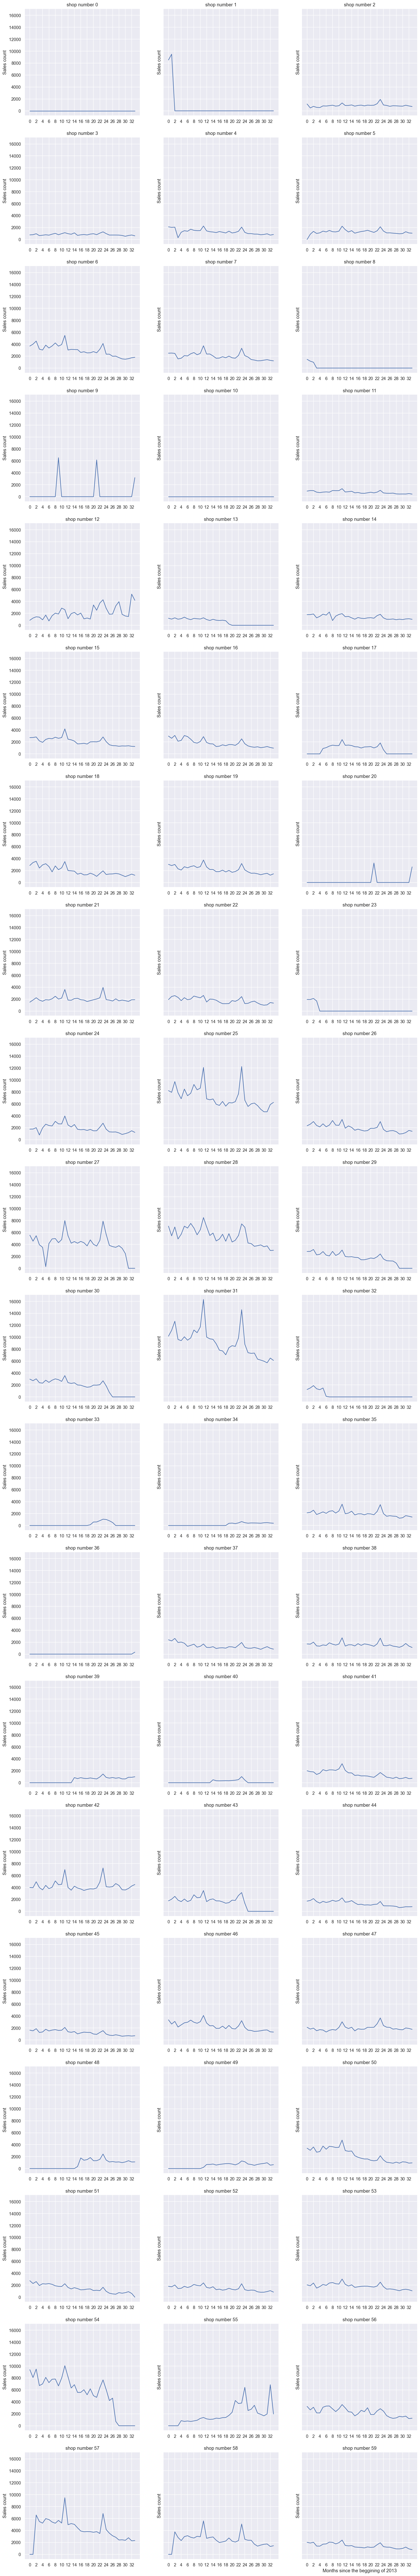

In [ ]:
fig, axes = plt.subplots(nrows=20, ncols=3, 
                         figsize=(18, 120), dpi=120,
                         sharex=False, sharey=True, 
                         subplot_kw={'xticks':range(0, 34, 2)})

for i, ax in enumerate(axes.reshape(60)):
    ax.plot(temp.loc[i].index, temp.loc[i])
    ax.set(title='shop number {}'.format(i), ylabel='Sales count')
    
plt.xlabel("Months since the beggining of 2013")
plt.show()

In [ ]:
# List all shops which are inactive
# We consider shops which did not sell any 
# goods in 3 months as inactive

inactive = list(temp.reset_index().query('date_block_num in [31, 32, 33]'). \
    groupby('shop_id').sum().rename({'monthly sales':'monthly_sales'}, axis=1). \
    query('monthly_sales < 1').index)

inactive

[0, 1, 8, 10, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 54]

In [ ]:
shops['inactive'] = shops['shop_id'].isin(inactive).astype(int)

In [ ]:
save('shops', shops)

### Popular in november

In [ ]:
temp['max_3'] = temp.apply(lambda row: row.nlargest(3).values[-1],axis=1)
temp['max_2'] = temp.apply(lambda row: row.nlargest(2).values[-1],axis=1)
temp['max_1'] = temp.apply(lambda row: row.nlargest(1).values[-1],axis=1)

x = temp[temp['max_1'] == temp[11]].copy()

In [ ]:
x['nov_popular'] = ((x['max_1'] > x['max_2'] + x['max_3']) & (x['max_1'] > 5)).astype(int)

In [ ]:
items['pop_in_nov'] = items['item_id'].isin(x.query('nov_popular > 0').index).astype(int)

In [ ]:
items[(items['pop_in_nov'] == True) & (items['inactive'] == 0)]

,item_name,item_id,item_category_id,inactive,pop_in_nov
1542,assassin s creed единство . bastille edition p...,1542,20,0,1
1548,assassin s creed единство . notre dame edition...,1548,29,0,1
1549,assassin s creed единство . notre dame edition...,1549,20,0,1
1550,assassin s creed единство . notre dame edition...,1550,24,0,1
2263,call of duty . ghosts + black ops ii pc jewel ...,2263,28,0,1
...,...,...,...,...,...
21623,человек из стали 3d bd+bd +3d открытка,21623,38,0,1
21682,черепашки ниндзя . выпуск 7 . старые друзья но...,21682,40,0,1
21918,штурм белого дома,21918,40,0,1
21960,шапка watch dogs beanie skull,21960,61,0,1


### Add weekends

In [ ]:
sales_train['day_of_week'] = sales_train['date'].dt.day_of_week
sales_train['weekend'] = sales_train['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
sales_train['unique_celebration'] = sales_train['date']. \
    isin(sales_train.query('(is_holiday == 1) & (weekend == 0)')['date']).astype(int)

In [ ]:
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']

In [ ]:
sales_train.groupby(['date']).mean().groupby('is_holiday').mean()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,day_of_week,weekend,unique_celebration,revenue
is_holiday,,,,,,,,,,,,
0.0,16.702190,32.715789,10192.604804,931.627410,1.256347,2013.940146,6.420438,16.284672,1.983942,0.000000,0.000000,1253.654337
1.0,16.174785,33.456042,10274.205929,875.892488,1.215592,2013.942693,5.862464,14.607450,4.994269,0.845272,0.154728,1056.532836


### Add sales of a previous month

In [ ]:
sales_train.sort_values(by=['date', 'shop_id', 'item_id'], inplace=True)

In [ ]:
x = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])[['item_cnt_day']].sum().reset_index()

In [ ]:
prev_sales = x.pivot_table(columns=['shop_id', 'item_id'], index='date_block_num', values='item_cnt_day', aggfunc='sum')

In [ ]:
prev_sales = prev_sales.shift(1).melt(value_name='previous_month_cnt')
prev_sales.reset_index(inplace=True)
prev_sales['date_block_num'] = prev_sales['index'] % 34
prev_sales.drop('index', axis=1, inplace=True)
prev_sales.fillna(0, inplace=True)
prev_sales

,index,shop_id,item_id,previous_month_cnt,date_block_num
0,0,1,27,NaN,0
1,1,1,27,1.0,1
2,2,1,27,NaN,2
3,3,1,27,NaN,3
4,4,1,27,NaN,4
...,...,...,...,...,...
14348743,14348743,59,22167,NaN,29
14348744,14348744,59,22167,NaN,30
14348745,14348745,59,22167,NaN,31
14348746,14348746,59,22167,NaN,32


In [ ]:
x = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])[['item_price']].sum().reset_index()
y = x.pivot_table(columns=['shop_id', 'item_id'], index='date_block_num', values='item_price', aggfunc='mean')
y = y.shift(1).melt(value_name='previous_month_price')
y.fillna(method='ffill', inplace=True)
y.reset_index(inplace=True)
y['date_block_num'] = y['index'] % 34
y.drop('index', axis=1, inplace=True)
y.fillna(method='bfill', inplace=True)

    shop_id  item_id  previous_month_price
0         1       27                   NaN
1         1       27                1890.0
2         1       27                1890.0
3         1       27                1890.0
4         1       27                1890.0
5         1       27                1890.0
6         1       27                1890.0
7         1       27                1890.0
8         1       27                1890.0
9         1       27                1890.0
10        1       27                1890.0
11        1       27                1890.0
12        1       27                1890.0
13        1       27                1890.0
14        1       27                1890.0
15        1       27                1890.0
16        1       27                1890.0
17        1       27                1890.0
18        1       27                1890.0
19        1       27                1890.0


,shop_id,item_id,previous_month_price,date_block_num
0,1,27,NaN,0
1,1,27,1890.0,1
2,1,27,1890.0,2
3,1,27,1890.0,3
4,1,27,1890.0,4
...,...,...,...,...
14348743,59,22167,299.0,29
14348744,59,22167,299.0,30
14348745,59,22167,299.0,31
14348746,59,22167,299.0,32


In [ ]:
previous_item_data = pd.merge(y, prev_sales)

In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,day,day_of_week,weekend
32569,2013-01-01,0,2,991,99.0,1.0,1.0,2013,1,1,1,0
32552,2013-01-01,0,2,1472,2599.0,1.0,1.0,2013,1,1,1,0
32632,2013-01-01,0,2,1905,249.0,1.0,1.0,2013,1,1,1,0
32459,2013-01-01,0,2,2920,599.0,2.0,1.0,2013,1,1,1,0
32504,2013-01-01,0,2,3320,1999.0,1.0,1.0,2013,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2899165,2015-10-31,33,59,20730,499.0,1.0,1.0,2015,10,31,5,1
2899147,2015-10-31,33,59,20866,699.0,1.0,1.0,2015,10,31,5,1
2899162,2015-10-31,33,59,20949,5.0,1.0,1.0,2015,10,31,5,1
2899141,2015-10-31,33,59,21369,169.0,1.0,1.0,2015,10,31,5,1


# Learning

## Groupby month in order to prepare for learning

In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday,year,month,day,day_of_week,weekend
0,2013-01-02,0,59,22154,999.00,1.0,0.0,2013,1,2,2,0
1,2013-01-03,0,25,2552,899.00,1.0,0.0,2013,1,3,3,0
2,2013-01-05,0,25,2552,899.00,-1.0,1.0,2013,1,5,5,1
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,2013,1,6,6,1
4,2013-01-15,0,25,2555,1099.00,1.0,0.0,2013,1,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,1.0,2015,10,10,5,1
2935845,2015-10-09,33,25,7460,299.00,1.0,0.0,2015,10,9,4,0
2935846,2015-10-14,33,25,7459,349.00,1.0,0.0,2015,10,14,2,0
2935847,2015-10-22,33,25,7440,299.00,1.0,0.0,2015,10,22,3,0


In [ ]:
sales_train.drop(['date', 'item_price', 'is_holiday', 'year', 'month', 'day', 'day_of_week', 'weekend'], axis=1, inplace=True)

In [ ]:
test.drop('ID', axis=1, inplace=True)
test['date_block_num'], test['item_cnt_day'] = 34, 0
test

,shop_id,item_id,date_block_num,item_cnt_day
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0
3,5,5232,34,0
4,5,5268,34,0
...,...,...,...,...
214195,45,18454,34,0
214196,45,16188,34,0
214197,45,15757,34,0
214198,45,19648,34,0


In [ ]:
sales_train

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
...,...,...,...,...
2935844,33,25,7409,1.0
2935845,33,25,7460,1.0
2935846,33,25,7459,1.0
2935847,33,25,7440,1.0


In [ ]:
sales_train = sales_train.groupby(['item_id', 'shop_id', 'date_block_num']).sum().reset_index()

In [ ]:
sales_train = sales_train.set_index(['item_id', 'shop_id', 'date_block_num']). \
    reset_index().sort_values(by=['item_id', 'shop_id', 'date_block_num'])

test = test.set_index(['item_id', 'shop_id', 'date_block_num']). \
    reset_index().sort_values(by=['item_id', 'shop_id', 'date_block_num'])

In [ ]:
x = test['shop_id'].unique()
y = test['item_id'].unique()

idx = sales_train.query('(shop_id in @x) & (item_id in @y)').index

sales_train = sales_train.loc[idx, :]
sales_train

,item_id,shop_id,date_block_num,item_cnt_day
162,30,2,2,1.0
163,30,2,5,1.0
164,30,2,15,1.0
165,30,2,16,1.0
166,30,3,1,4.0
...,...,...,...,...
1607123,22167,58,14,1.0
1607124,22167,58,20,1.0
1607125,22167,59,9,1.0
1607126,22167,59,11,2.0


In [ ]:
zeros = pd.DataFrame(data=35*len(x)*len(y)*[0], index=pd.MultiIndex.from_product([x, y, range(35)]))
zeros.reset_index(inplace=True)
zeros.columns = ['shop_id', 'item_id', 'date_block_num', 'dummy']

In [ ]:
sales_train = pd.merge(zeros, sales_train, how='left').fillna(0)

In [ ]:
items_mon = items_mon.melt().reset_index()
items_mon['index'] = items_mon['index'] % 35
items_mon.rename({'index':'date_block_num', 'value':'is_active'}, axis=1, inplace=True)
items_mon

,date_block_num,item_id,is_active
0,0,30,True
1,1,30,True
2,2,30,True
3,3,30,True
4,4,30,True
...,...,...,...
178495,30,22167,True
178496,31,22167,True
178497,32,22167,True
178498,33,22167,True


In [ ]:
sales_train = pd.merge(sales_train, items_mon)
sales_train.drop(sales_train.query('is_active == False').index, inplace=True)
sales_train.drop('dummy', axis=1, inplace=True)

In [ ]:
train = sales_train.copy()

In [ ]:
train = pd.merge(train, items)
train = pd.merge(train, categ)
train

,shop_id,item_id,date_block_num,item_cnt_day,is_active,item_name,item_category_id,inactive,item_category_name,type
0,2,30,0,0.0,True,007 координаты «скайфолл»,40,0,Кино - DVD,Кино
1,3,30,0,0.0,True,007 координаты «скайфолл»,40,0,Кино - DVD,Кино
2,4,30,0,0.0,True,007 координаты «скайфолл»,40,0,Кино - DVD,Кино
3,5,30,0,0.0,True,007 координаты «скайфолл»,40,0,Кино - DVD,Кино
4,6,30,0,0.0,True,007 координаты «скайфолл»,40,0,Кино - DVD,Кино
...,...,...,...,...,...,...,...,...,...,...
3416905,55,22092,34,0.0,True,элемент питания duracell turbo lr6 2*bl,83,0,Элементы питания,Элементы
3416906,56,22092,34,0.0,True,элемент питания duracell turbo lr6 2*bl,83,0,Элементы питания,Элементы
3416907,57,22092,34,0.0,True,элемент питания duracell turbo lr6 2*bl,83,0,Элементы питания,Элементы
3416908,58,22092,34,0.0,True,элемент питания duracell turbo lr6 2*bl,83,0,Элементы питания,Элементы


In [ ]:
train.drop(['item_name', 'inactive', 'item_category_name', 'is_active'], axis=1, inplace=True)
save('train', train, fast='')

train

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,type
0,2,30,0,0.0,40,Кино
1,3,30,0,0.0,40,Кино
2,4,30,0,0.0,40,Кино
3,5,30,0,0.0,40,Кино
4,6,30,0,0.0,40,Кино
...,...,...,...,...,...,...
3416905,55,22092,34,0.0,83,Элементы
3416906,56,22092,34,0.0,83,Элементы
3416907,57,22092,34,0.0,83,Элементы
3416908,58,22092,34,0.0,83,Элементы


In [ ]:
holidays['date_block_num'] = 12 * (holidays['date'].dt.year - 2013) + holidays['date'].dt.month - 1
holidays = holidays.groupby('date_block_num')[['is_holiday']].sum()
holidays.reset_index(inplace=True)
holidays

,date_block_num,is_holiday
0,0,14
1,1,9
2,2,12
3,3,8
4,4,14
5,5,12
6,6,8
7,7,9
8,8,9
9,9,8


## Encode item id as an order of 'popularity' of an item

In [ ]:
train

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,type
0,2,30,0,0.0,40,Кино
1,3,30,0,0.0,40,Кино
2,4,30,0,0.0,40,Кино
3,5,30,0,0.0,40,Кино
4,6,30,0,0.0,40,Кино
...,...,...,...,...,...,...
3416905,55,22092,34,0.0,83,Элементы
3416906,56,22092,34,0.0,83,Элементы
3416907,57,22092,34,0.0,83,Элементы
3416908,58,22092,34,0.0,83,Элементы


In [ ]:
popularity = train.groupby('item_id')[['item_cnt_day']].sum(). \
    reset_index().sort_values(by='item_cnt_day', ascending=False). \
    reset_index(drop=True).reset_index().rename({'index':'popularity'}).drop('item_cnt_day', axis=1)

In [ ]:
popularity = dict(zip(popularity['index'], popularity['item_id']))

{0: 20949,
 1: 2808,
 2: 17717,
 3: 5822,
 4: 3732,
 5: 16787,
 6: 4181,
 7: 7856,
 8: 6675,
 9: 3734,
 10: 11373,
 11: 2308,
 12: 11370,
 13: 2445,
 14: 4870,
 15: 6738,
 16: 5823,
 17: 3331,
 18: 5821,
 19: 6503,
 20: 6497,
 21: 6740,
 22: 7894,
 23: 5272,
 24: 22088,
 25: 4178,
 26: 6457,
 27: 7893,
 28: 2416,
 29: 5672,
 30: 2753,
 31: 1905,
 32: 1916,
 33: 4244,
 34: 7070,
 35: 12134,
 36: 9355,
 37: 3077,
 38: 16790,
 39: 6488,
 40: 1495,
 41: 3076,
 42: 3341,
 43: 3329,
 44: 3343,
 45: 5820,
 46: 3928,
 47: 4872,
 48: 3851,
 49: 4248,
 50: 4351,
 51: 3719,
 52: 15063,
 53: 2252,
 54: 4806,
 55: 3340,
 56: 4249,
 57: 22087,
 58: 2269,
 59: 16169,
 60: 10298,
 61: 16227,
 62: 6185,
 63: 3731,
 64: 21440,
 65: 11369,
 66: 14227,
 67: 4231,
 68: 3335,
 69: 7018,
 70: 5643,
 71: 16056,
 72: 7172,
 73: 3556,
 74: 7967,
 75: 7834,
 76: 3342,
 77: 5811,
 78: 7071,
 79: 20608,
 80: 482,
 81: 3695,
 82: 492,
 83: 972,
 84: 13881,
 85: 21404,
 86: 3328,
 87: 15045,
 88: 4904,
 89: 3733,
 9

In [ ]:
train = pd.merge(train, holidays)
train = pd.merge(train, shops)
train.drop('inactive', axis=1, inplace=True)

train

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,type,is_holiday,city,is_tc,is_tr,is_tk,is_trc,overprice_ratio
0,2,30,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
1,2,32,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
2,2,72,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
3,2,88,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
4,2,8144,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335550,59,20949,34,0.0,71,Подарки,11,Ярославль,1,0,0,0,0.984052
3335551,59,22087,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052
3335552,59,22088,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052
3335553,59,22091,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052


In [ ]:
save('train', train, fast='')

In [ ]:
train = read('train', fast='')

In [ ]:
train

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,type,is_holiday,city,is_tc,is_tr,is_tk,is_trc,overprice_ratio
0,2,30,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
1,2,32,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
2,2,72,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
3,2,88,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
4,2,8144,0,0.0,40,Кино,14,Адыгея,1,0,0,0,0.985052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335550,59,20949,34,0.0,71,Подарки,11,Ярославль,1,0,0,0,0.984052
3335551,59,22087,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052
3335552,59,22088,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052
3335553,59,22091,34,0.0,83,Элементы,11,Ярославль,1,0,0,0,0.984052


In [ ]:
CATEG_DUMMY = pd.get_dummies(train['item_category_id']) 
CATEG_DUMMY.columns = ['item_category_' + str(c) for c in CATEG_DUMMY.columns]
CATEG_DUMMY

pd.merge(train.drop('item_category_id', axis=1), CATEG_DUMMY, left_index=True, right_index=True)

MemoryError: Unable to allocate 130. MiB for an array with shape (41, 3335555) and data type uint8

In [ ]:
for c in ['shop', 'item_category']:
    TRAIN_DUMMIE = pd.get_dummies(train['{}_id'.format(c)])

    TRAIN_DUMMIE.columns = ['{}_id'.format(c) + str(column) for column in TRAIN_DUMMIE.columns]
    train = pd.merge(train.drop('{}_id'.format(c), axis=1), TRAIN_DUMMIE, left_index=True, right_index=True)
    
train

MemoryError: Unable to allocate 191. MiB for an array with shape (60, 3335555) and data type uint8

In [ ]:
train 

,date_block_num,item_cnt_day,type,index,is_holiday,city,is_tc,is_tr,is_tk,is_trc,...,71,72,73,74,75,76,77,78,79,83
0,0,0.0,Кино,140,14,Адыгея,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,Кино,123,14,Адыгея,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,Кино,3016,14,Адыгея,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,Кино,3304,14,Адыгея,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,Кино,2780,14,Адыгея,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335550,34,0.0,Подарки,0,11,Ярославль,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3335551,34,0.0,Элементы,57,11,Ярославль,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3335552,34,0.0,Элементы,24,11,Ярославль,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3335553,34,0.0,Элементы,254,11,Ярославль,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
pd.get_dummies(train)

,shop_id,date_block_num,item_cnt_day,item_category_id,index,is_holiday,is_tc,is_tr,is_tk,is_trc,...,city_СПб,city_Самара,city_Сергиев,city_Сургут,city_Томск,city_Тюмень,city_Уфа,city_Чехов,city_Якутск,city_Ярославль
0,2,0,0.0,40,140,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0.0,40,123,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0.0,40,3016,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0.0,40,3304,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0.0,40,2780,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335550,59,34,0.0,71,0,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3335551,59,34,0.0,83,57,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3335552,59,34,0.0,83,24,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3335553,59,34,0.0,83,254,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# train = pd.merge(train, popularity).drop('item_id', axis=1)

pd.get_dummies(train[['item_category_id', 'shop_id', 'type']])
train

,shop_id,date_block_num,item_cnt_day,item_category_id,type,index
0,2,0,0.0,40,Кино,140
1,3,0,0.0,40,Кино,140
2,4,0,0.0,40,Кино,140
3,5,0,0.0,40,Кино,140
4,6,0,0.0,40,Кино,140
...,...,...,...,...,...,...
3416905,55,34,0.0,83,Элементы,119
3416906,56,34,0.0,83,Элементы,119
3416907,57,34,0.0,83,Элементы,119
3416908,58,34,0.0,83,Элементы,119


In [ ]:
X = train.drop('item_id', axis=1)
y = train['item_id']

X, y

(         shop_id  date_block_num  item_cnt_day  item_category_id      type
 0              2               0           0.0                40      Кино
 1              3               0           0.0                40      Кино
 2              4               0           0.0                40      Кино
 3              5               0           0.0                40      Кино
 4              6               0           0.0                40      Кино
 ...          ...             ...           ...               ...       ...
 3416905       55              34           0.0                83  Элементы
 3416906       56              34           0.0                83  Элементы
 3416907       57              34           0.0                83  Элементы
 3416908       58              34           0.0                83  Элементы
 3416909       59              34           0.0                83  Элементы
 
 [3416910 rows x 5 columns],
 0             30
 1             30
 2             30
 3 

In [ ]:
y

0             30
1             30
2             30
3             30
4             30
           ...  
3416905    22092
3416906    22092
3416907    22092
3416908    22092
3416909    22092
Name: item_id, Length: 3416910, dtype: int64

In [ ]:
import keras 

if we try to create dummy columns for all items, we face memory usage problem: size of DataFrame reaches critical number.
Possible solutions:
    1) leave items as id's
    2) Change datatypes from int8 to int1, leave only shops and items, 
       which appears in test/train dataset, turn matrix into sparse form
    3) Vectorize item_id's in order for vector to represent some features of this particular number

In [ ]:
X = pd.get_dummies(train). \
    join(pd.get_dummies(train['shop_id'], prefix='shop', sparse=True, dtype=np.bool_)).\
    join(pd.get_dummies(train['item_id'], prefix='item', sparse=True, dtype=np.bool_))

X.drop(['shop_id', 'item_id'], axis=1, inplace=True)

In [ ]:
val = X.loc[x.query('date_block_num == 33').index, :]
train = X.loc[x.query('date_block_num != 33').index, :]

val_X = val.drop('item_cnt_month', axis=1)
train_X = train.drop('item_cnt_month', axis=1)

val_y = val['item_cnt_month']
train_y = train['item_cnt_month']

In [ ]:
train_X, train_y

(         date_block_num  year  month  index  is_holiday  is_tc  is_tr  is_tk  \
 0                     0  2013      1      0          14      1      0      0   
 1                     1  2013      2      1           9      1      0      0   
 2                     2  2013      3      2          12      1      0      0   
 3                     3  2013      4      3           8      1      0      0   
 4                     4  2013      5      4          14      1      0      0   
 ...                 ...   ...    ...    ...         ...    ...    ...    ...   
 6918416              28  2015      5     28          14      1      0      0   
 6918417              29  2015      6     29          10      1      0      0   
 6918418              30  2015      7     30           8      1      0      0   
 6918419              31  2015      8     31          10      1      0      0   
 6918420              32  2015      9     32           8      1      0      0   
 
          is_trc  shop_is_

# Learning

In [ ]:
regr = RandomForestRegressor(max_depth=50, criterion='RMSE')
regr.fit(train_x, train_y)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MemoryError: Unable to allocate 253. GiB for an array with shape (5056, 6714939) and data type float64

We do not have enough memory for making regression, so we try to convert item_id's in vector form

In [ ]:
train = sales_train_cut.groupby(['shop_id', 'item_id', 'date_block_num']). \
    agg({'is_holiday':'sum', 'year':'mean', 'month':'mean', 'weekend':'sum', 'item_cnt_day':'sum'}). \
    reset_index()

for_pca = pd.merge(zeros, train, how='outer')
for_pca = for_pca.fillna(0).drop(['is_holiday', 'year', 'month', 'weekend', 'dummy'], axis=1)
for_pca

,shop_id,item_id,date_block_num,item_cnt_day
0,2,22,0,0.0
1,2,22,1,0.0
2,2,22,2,0.0
3,2,22,3,0.0
4,2,22,4,0.0
...,...,...,...,...
16127725,59,22167,29,0.0
16127726,59,22167,30,0.0
16127727,59,22167,31,0.0
16127728,59,22167,32,0.0


In [ ]:
for_pca = pd.merge(for_pca, items).drop('item_name', axis=1).rename({'inactive':'item_is_inactive'}, axis=1)
for_pca = pd.merge(for_pca, shops).rename({'inactive':'shop_is_inactive'}, axis=1)
for_pca

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_is_inactive,city,is_tc,is_tr,is_tk,is_trc,shop_is_inactive,overprice_ratio
0,2,22,0,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
1,2,22,1,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
2,2,22,2,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
3,2,22,3,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
4,2,22,4,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16127725,59,22167,29,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127726,59,22167,30,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127727,59,22167,31,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127728,59,22167,32,0.0,49,0,Ярославль,1,0,0,0,0,0.984052


In [ ]:
idx = for_pca.query('(shop_id in @x) & (item_id in @y) & (item_is_inactive == 0) & (shop_is_inactive == 0)').index
for_pca = for_pca.loc[idx, :]
for_pca

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_is_inactive,city,is_tc,is_tr,is_tk,is_trc,shop_is_inactive,overprice_ratio
68,2,30,0,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
69,2,30,1,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
70,2,30,2,1.0,40,0,Адыгея,1,0,0,0,0,0.985052
71,2,30,3,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
72,2,30,4,0.0,40,0,Адыгея,1,0,0,0,0,0.985052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16127725,59,22167,29,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127726,59,22167,30,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127727,59,22167,31,0.0,49,0,Ярославль,1,0,0,0,0,0.984052
16127728,59,22167,32,0.0,49,0,Ярославль,1,0,0,0,0,0.984052


In [ ]:
for_pca.drop(['shop_is_inactive', 'item_is_inactive', 'city', 'is_tc', 'is_tr', 'is_tk', 'is_trc', 'overprice_ratio'],
             axis=1, inplace=True)
for_pca = for_pca.sort_values(by=['item_id', 'date_block_num', 'shop_id']).set_index(['item_id', 'date_block_num'])
for_pca

item_cnt_day  item_category_id
item_id shop_id date_block_num                                
30      2       0                        0.0                40
        3       0                        0.0                40
        4       0                        0.0                40
        5       0                        0.0                40
        6       0                        0.0                40
...                                      ...               ...
22167   55      33                       0.0                49
        56      33                       0.0                49
        57      33                       0.0                49
        58      33                       0.0                49
        59      33                       0.0                49

[6918422 rows x 2 columns]

In [ ]:
for_pca.reset_index(inplace=True)
for_pca

,item_id,date_block_num,shop_id,item_cnt_day,item_category_id
0,30,0,2,0.0,40
1,30,0,3,0.0,40
2,30,0,4,0.0,40
3,30,0,5,0.0,40
4,30,0,6,0.0,40
...,...,...,...,...,...
6918417,22167,33,55,0.0,49
6918418,22167,33,56,0.0,49
6918419,22167,33,57,0.0,49
6918420,22167,33,58,0.0,49


In [ ]:
for_pca.iloc[range(41)]

,item_id,date_block_num,shop_id,item_cnt_day,item_category_id
0,30,0,2,0.0,40
1,30,0,3,0.0,40
2,30,0,4,0.0,40
3,30,0,5,0.0,40
4,30,0,6,0.0,40
5,30,0,7,0.0,40
6,30,0,12,0.0,40
7,30,0,14,0.0,40
8,30,0,15,0.0,40
9,30,0,16,0.0,40


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_holiday_x,year,month,day,day_of_week,weekend,is_holiday_y
0,2013-01-02,0,59,22154,999.00,1.0,0.0,2013,1,2,2,0,1.0
1,2013-01-03,0,25,2552,899.00,1.0,0.0,2013,1,3,3,0,1.0
2,2013-01-05,0,25,2552,899.00,-1.0,1.0,2013,1,5,5,1,1.0
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,2013,1,6,6,1,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,0.0,2013,1,15,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,1.0,2015,10,10,5,1,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0,0.0,2015,10,9,4,0,0.0
2935846,2015-10-14,33,25,7459,349.00,1.0,0.0,2015,10,14,2,0,0.0
2935847,2015-10-22,33,25,7440,299.00,1.0,0.0,2015,10,22,3,0,0.0


In [ ]:
for_pca.reset_index(inplace=True)

In [ ]:
for_pca.set_index(['item_id', 'date_block_num'], inplace=True)

In [ ]:
for_pca.reset_index(inplace=True)
for_pca

,shop_id,item_cnt_day,item_category_id
0,2,0.0,40
1,3,0.0,40
2,4,0.0,40
3,5,0.0,40
4,6,0.0,40
...,...,...,...
6918417,55,0.0,49
6918418,56,0.0,49
6918419,57,0.0,49
6918420,58,0.0,49


In [ ]:

temp = for_pca.loc[[30, 0], ['item_cnt_day', 'item_categories_id']]

KeyError: '[0] not in index'

In [ ]:
for_pca

In [ ]:
np.array(for_pca.loc[range(0, 34), 'item_cnt_day'])

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])